In [35]:
class DistributionAnalysis:
    def __init__(self, sam_model="vit_b"):
        self.model_name = sam_model
        self.model_registry = None
        self.images = None
        self.masks = []
        self.areas = []
        self.load_sam()
        self.image_path = None
        

    def load_sam(self):
        from segment_anything import sam_model_registry
        sam_checkpoint = "SAM_Models/" + self.model_name + ".pth"

        sam = sam_model_registry[self.model_name](checkpoint=sam_checkpoint)
        _ = sam.to(device="cuda")

        self.model_registry = sam

    def load_image_batch(self, path, downscale_factor=2):
        import os
        import cv2 as cv
        from skimage.transform import downscale_local_mean
        from tqdm import tqdm
        from skimage import filters
        
        self.image_path = path

        files = os.listdir(path)
        files = [file for file in files if file.endswith(".tif")]
        images = []
        print("Found", len(files), "images.")
        print("Loading images...")
        for file in tqdm(files):
            im = cv.imread(path + file)
            im = downscale_local_mean(im, (downscale_factor, downscale_factor, 1)).astype("uint8")
            # im = filters.median(im).astype("uint8")
            # dst = cv.fastNlMeansDenoisingColored(im, None, 5, 10, 14, 51)
            # im = filters.gaussian(dst, sigma=1, preserve_range=True).astype("uint8")
            images.append(im)
            

        self.images = images

    def __create_segmentation(self, image, pred_iou_thresh=0.95, stability_score_thresh=0.95,
                            crop_n_layers=2, crop_n_points_downscale_factor=1, min_mask_region_area=0, n_x_y: tuple[int, int] | None = None):
        from segment_anything import SamAutomaticMaskGenerator
        from typing import List
        import numpy as np
        

        def build_point_grid(n_x:int, n_y:int) -> np.ndarray:
            """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
            from itertools import product
            offset_x = 1 / (2 * n_x)
            offset_y = 1 / (2 * n_y)
            xx = np.linspace(0+offset_x, 1-offset_x, n_x)
            yy = np.linspace(0+offset_y, 1-offset_y, n_y)
            points = np.array(list(product(xx, yy)))
            return points

        def build_all_layer_point_grids(
                n_per_side: tuple[int, int], n_layers: int, scale_per_layer: int
        ) -> List[np.ndarray]:
            """Generates point grids for all crop layers."""
            points_by_layer = []
            for i in range(n_layers + 1):
                n_x = int(n_per_side[0] / (scale_per_layer**i))
                n_y = int(n_per_side[1] / (scale_per_layer**i))
                points_by_layer.append(build_point_grid(n_x, n_y))
            return points_by_layer
        
        if n_x_y is None:
            n_x_y = (32, 18)
        
        mask_generator = SamAutomaticMaskGenerator(
            model=self.model_registry,
            points_per_side=None,
            point_grids=build_all_layer_point_grids(n_x_y, crop_n_layers, crop_n_points_downscale_factor),
            pred_iou_thresh=pred_iou_thresh,
            stability_score_thresh=stability_score_thresh,
            crop_n_layers=crop_n_layers,
            crop_n_points_downscale_factor=crop_n_points_downscale_factor,
            min_mask_region_area=min_mask_region_area,
        )
        return mask_generator.generate(image)
    
    def get_masks(self, **kwargs):
        from tqdm import tqdm
        
        print("Generating {} masks...".format(len(self.images)))
        for image in tqdm(self.images):
            masks = self.__create_segmentation(image, **kwargs)
            self.masks.append(masks)

    def __show_anns(self, anns, transparency=0.7):
        import numpy as np
        import matplotlib.pyplot as plt
        
        
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)

        img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
        img[:, :, 3] = 0
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [transparency]])
            img[m] = color_mask
        ax.imshow(img)
        
    def show_segmentation(self, n=1):
        import matplotlib.pyplot as plt
        if n > len(self.images):
            n = len(self.images)
        
        for i in range(n):
            plt.figure(figsize=(20,20))
            plt.imshow(self.images[i])
            self.__show_anns(self.masks[i])
            plt.show()
            
    def save_segmentations(self, path):
        from tqdm import tqdm
        import matplotlib.pyplot as plt
        import os
        
        if not os.path.exists(path):
            os.makedirs(path)
        
        ii = 0
        for image, mask in tqdm(zip(self.images, self.masks)):
            plt.figure(figsize=(20,20))
            plt.imshow(image)
            self.__show_anns(mask)
            plt.savefig(path + str(ii) + ".png", bbox_inches="tight", dpi="figure")
            plt.close()
            ii += 1

    def get_areas(self):
        from scipy import stats
        areas = [mask["area"]
                 for masks in self.masks
                 for mask in masks]

        # filter out outliers
        z_scores = stats.zscore(areas)
        self.areas = [area for i, area in enumerate(areas) if z_scores[i] < 1]
        if len(z_scores) < len(self.areas):
            print("Removed", len(z_scores) - len(self.areas), "outliers.")
            print("This was probably wrongly segmented background.")
        
    
    def density_plot(self, smoothing=0.5):
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        sns.kdeplot(self.areas, ax=ax, fill=True, bw_adjust=smoothing)
        ax.set_title("Distribution of particle areas with n = " + str(len(self.areas)))
        plt.show()
        
    def to_pickle(self, path):
        """Export only areas and masks to a pickle file."""
        import pickle
        with open(path, "wb") as f:
            pickle.dump({"areas": self.areas, "masks": self.masks}, f)
    

In [20]:
import os
folder = "../../../Data/Structured_Al/Batch7/LM/"
os.listdir(folder)

True

C:\Users\malte\OneDrive\Documents\StudiumDocs\MatSci_Ma\Thesis\Computation\Calculations\ParticleStatistics\segment-anything-main\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

Found 5 images.
Loading images...


100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Generating 5 masks...


100%|██████████| 5/5 [09:03<00:00, 108.65s/it]


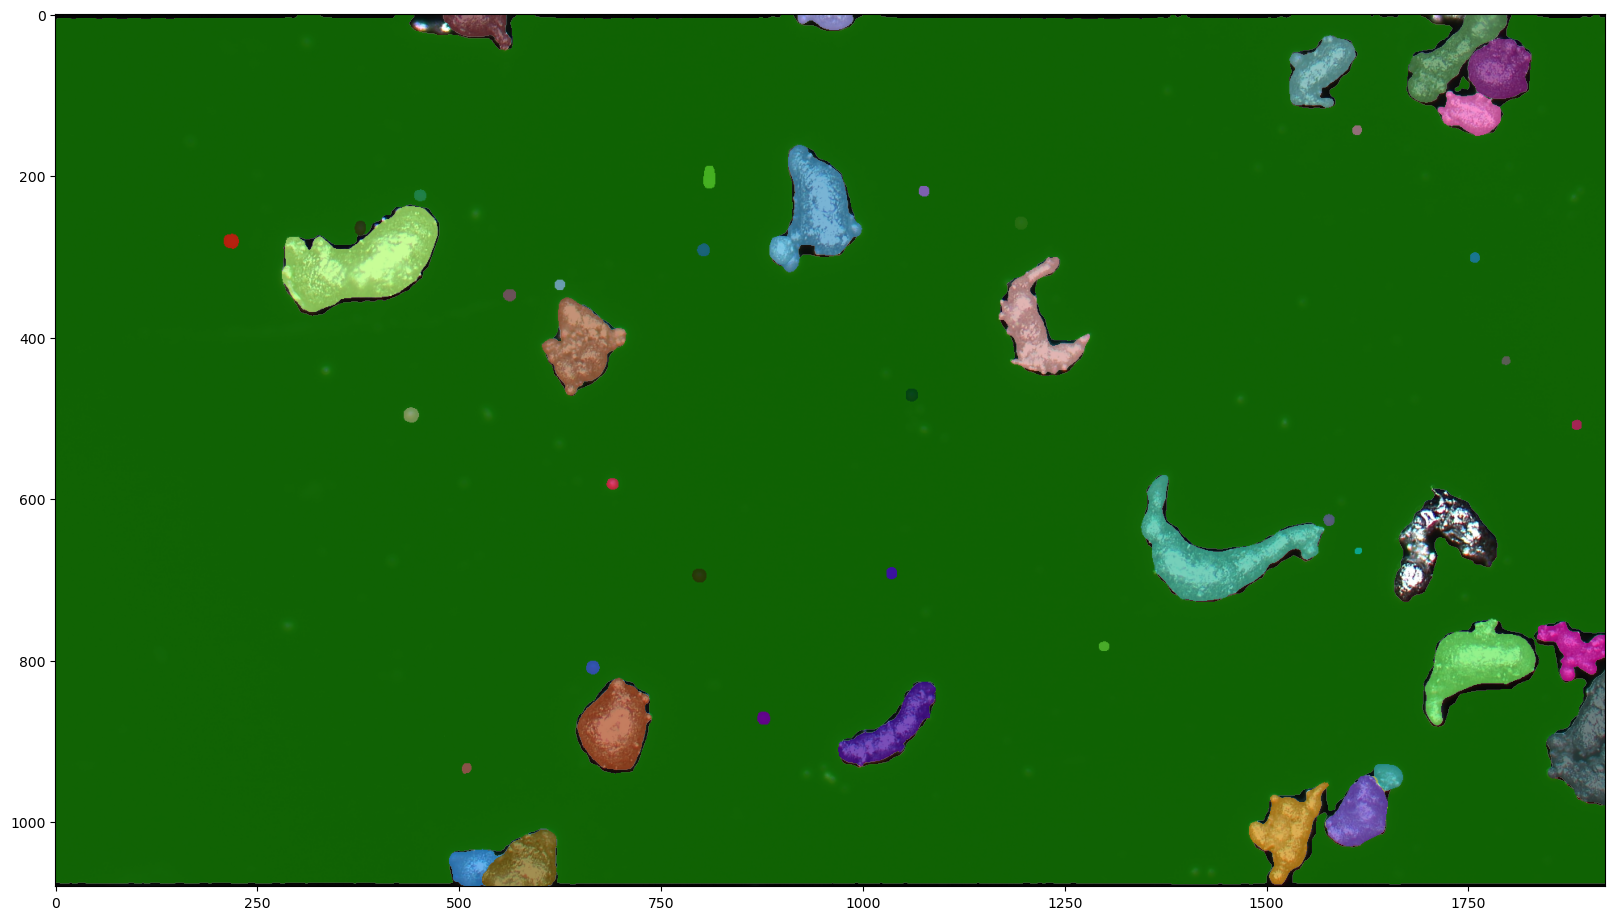

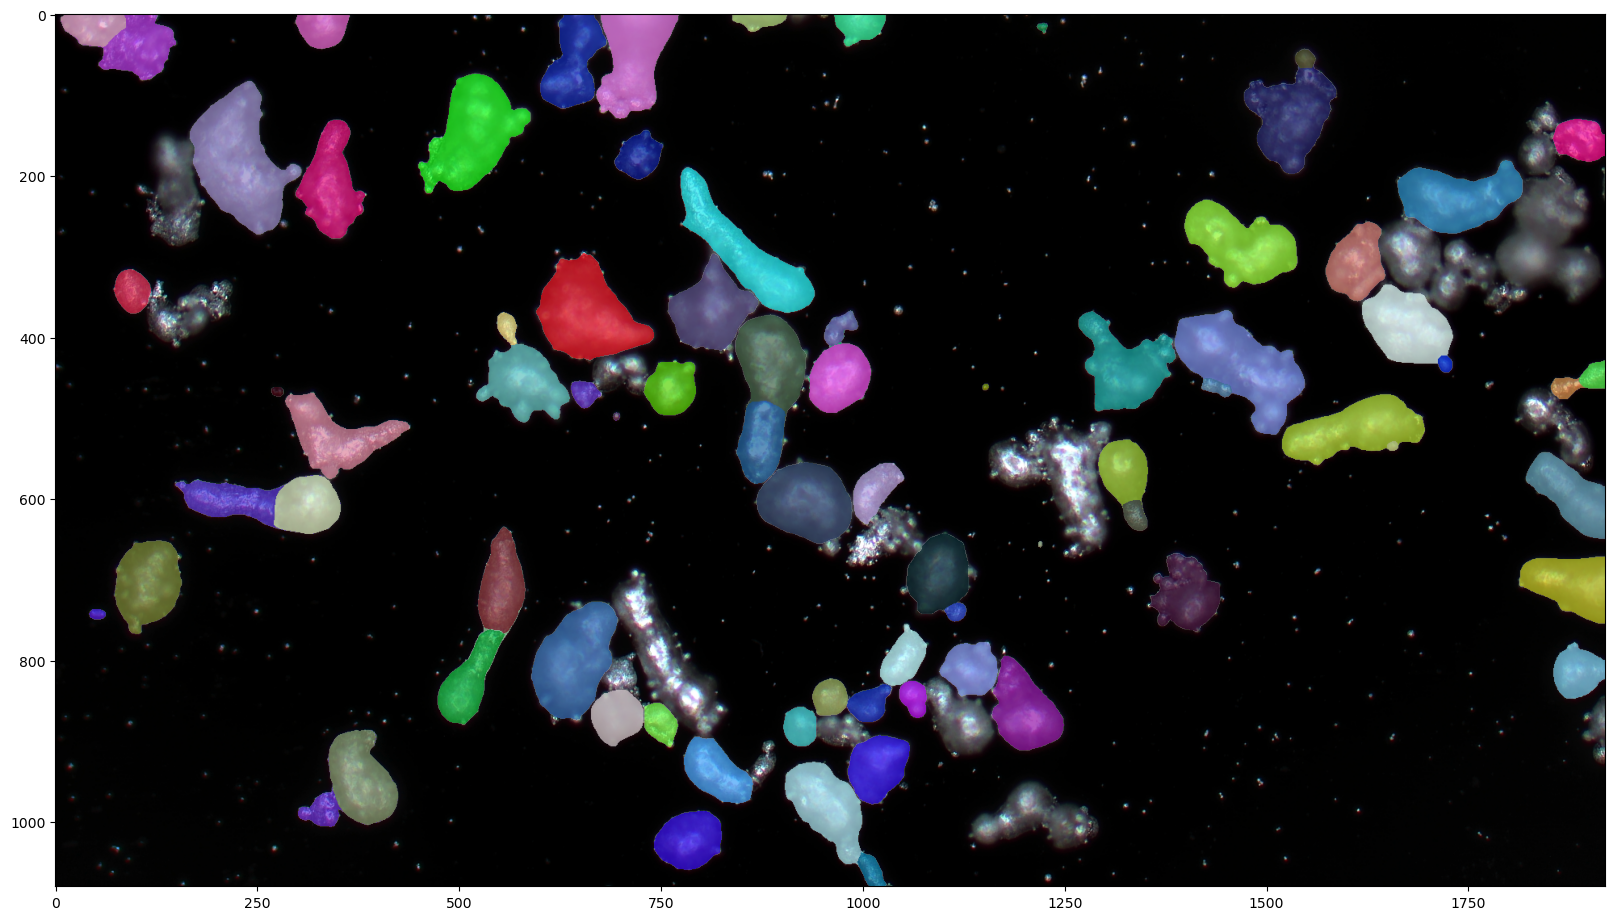

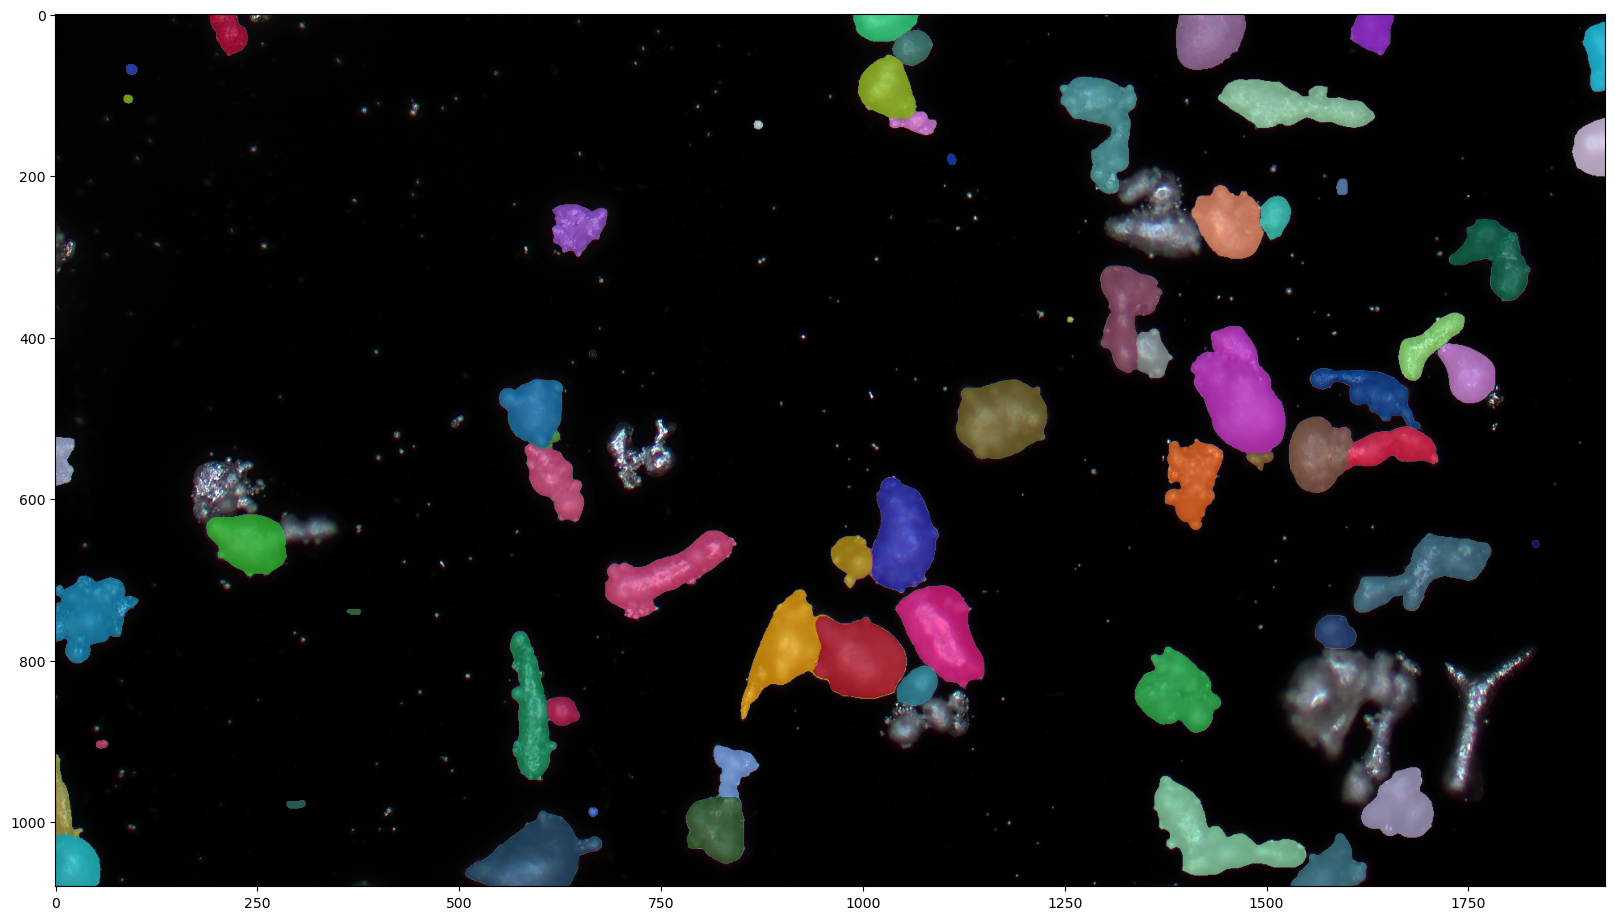

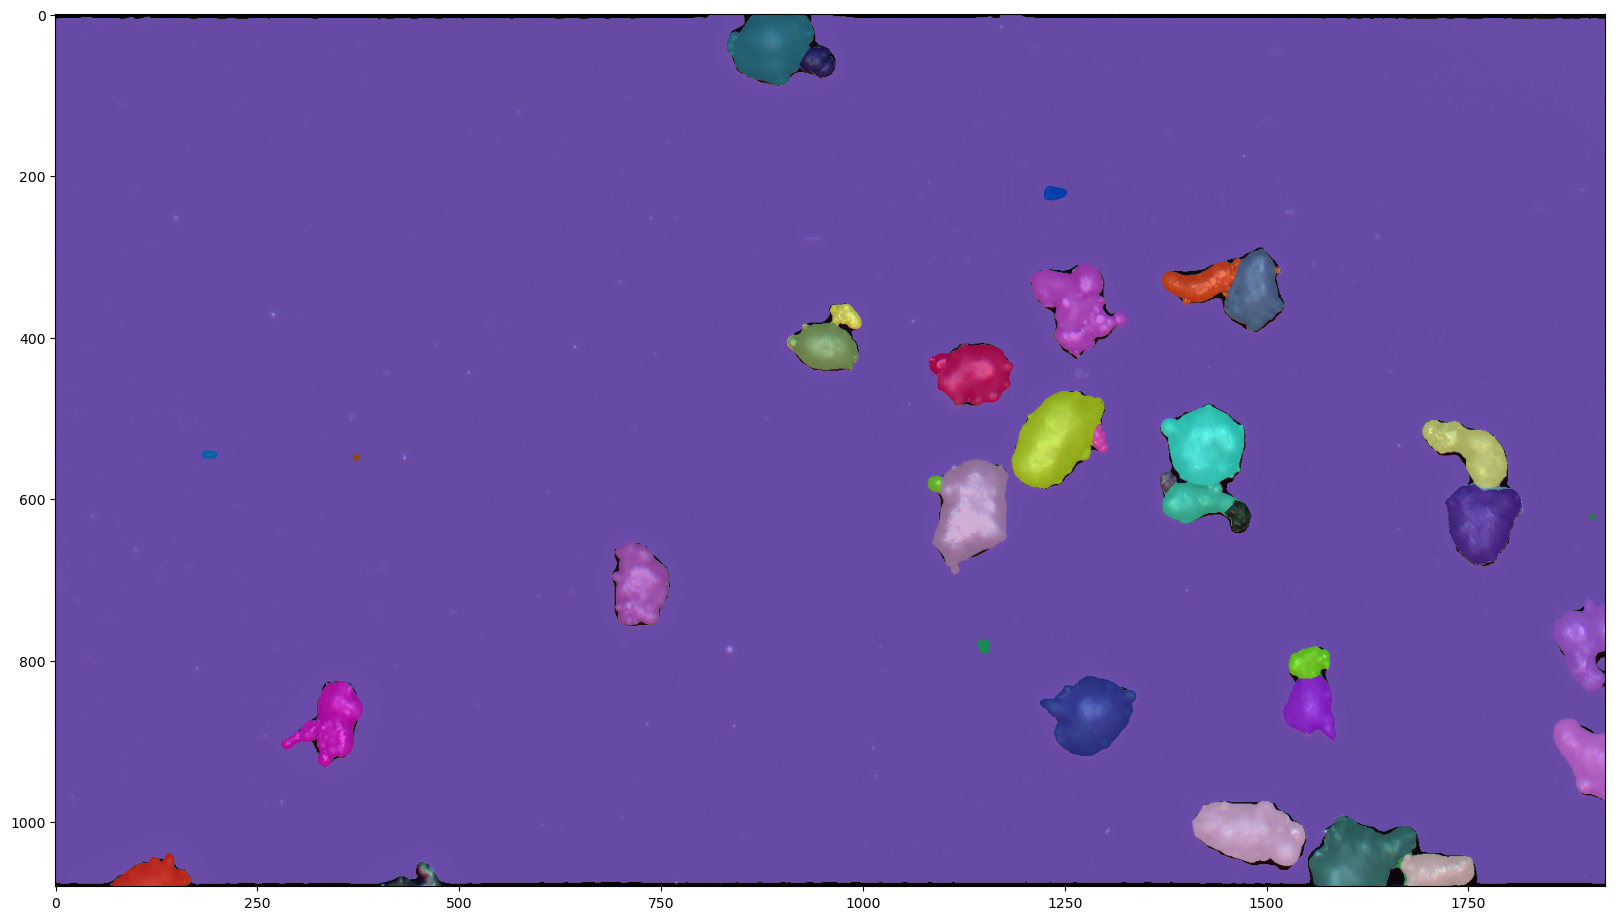

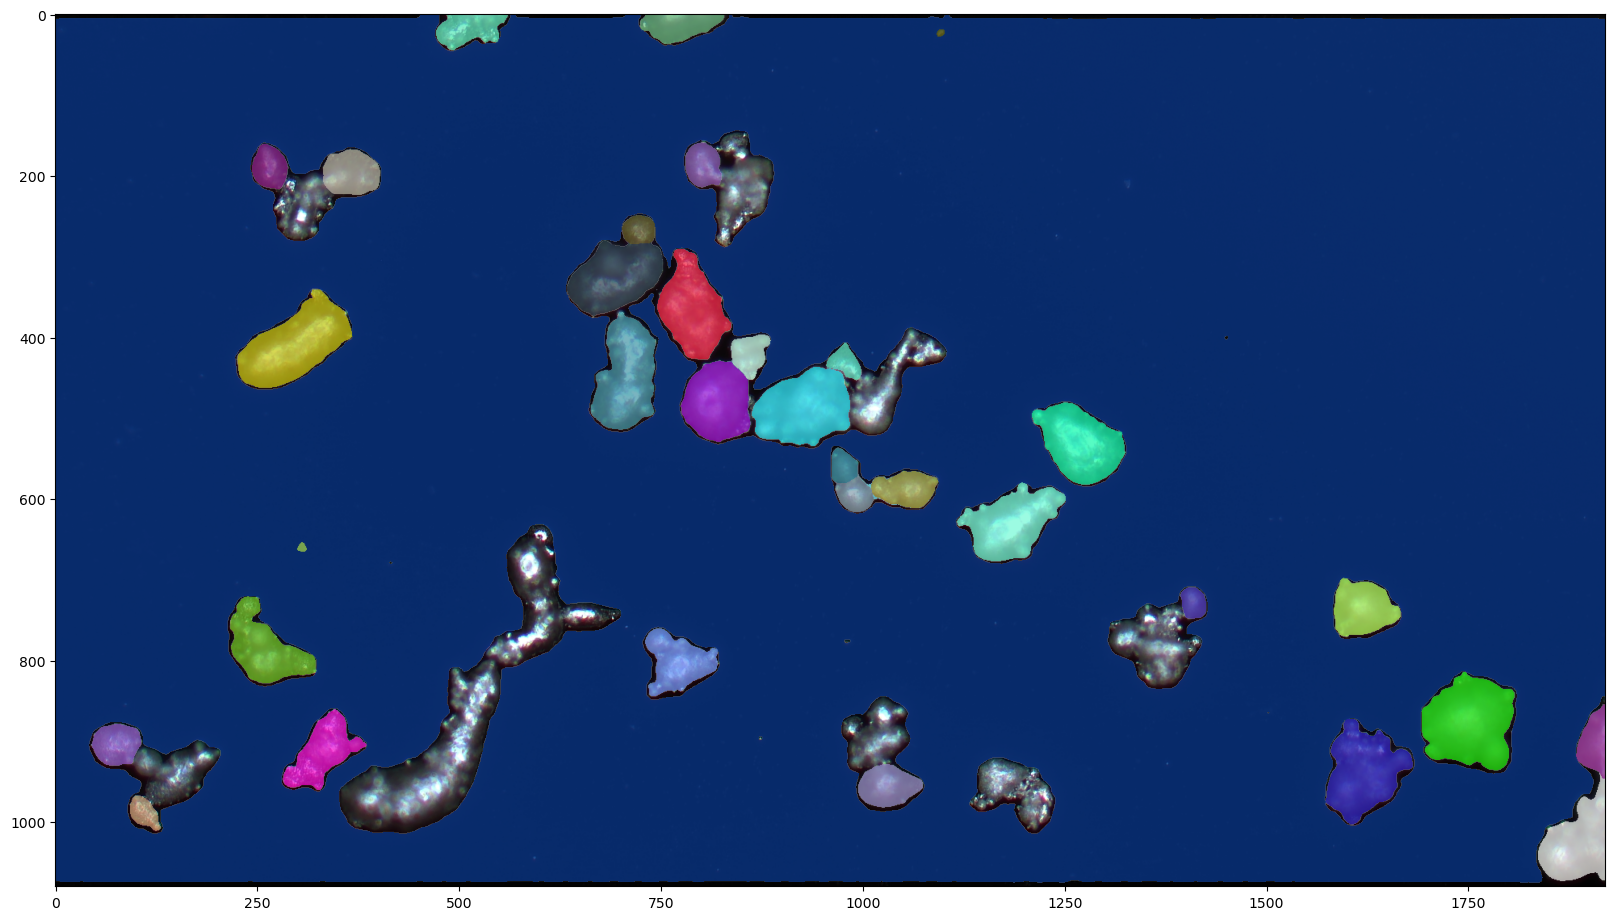

In [70]:
import numpy as np
folder = "samples/"
da = DistributionAnalysis(sam_model="vit_l")
da.load_image_batch(folder, downscale_factor=2)
da.get_masks(crop_n_layers=1,
             crop_n_points_downscale_factor=1, 
             n_x_y=np.array([32, 18]),
             pred_iou_thresh=0.90, 
             stability_score_thresh=0.98,)
da.show_segmentation(n=10)

In [47]:
da.save_segmentations("data/B7/segmentations/")

5it [00:05,  1.02s/it]


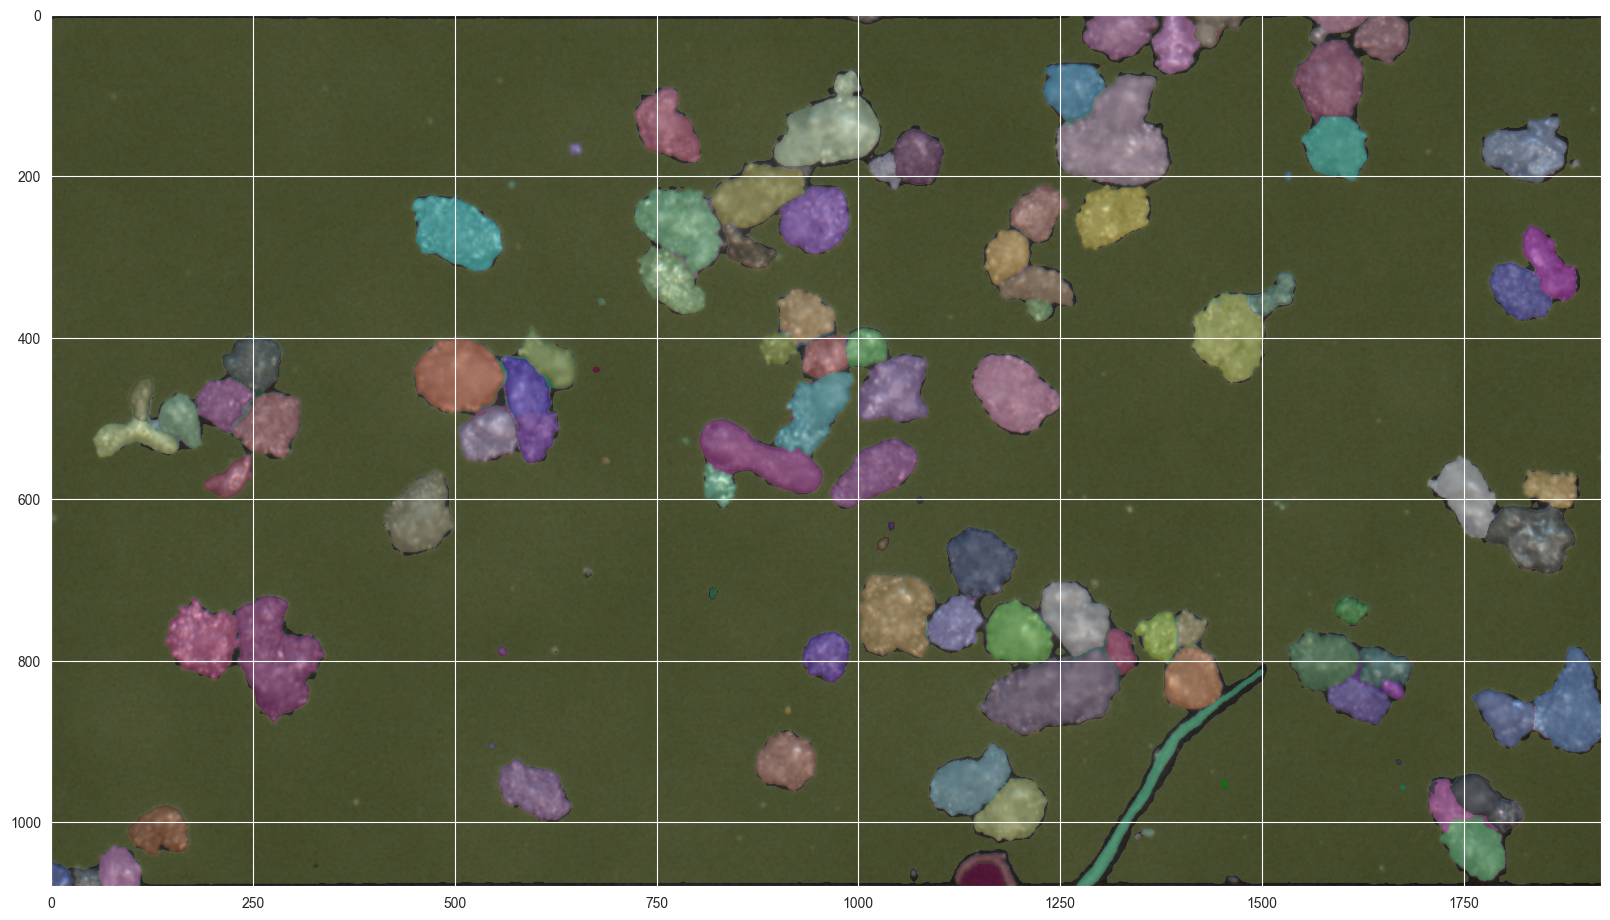

In [86]:
da.show_segmentation(n=49)

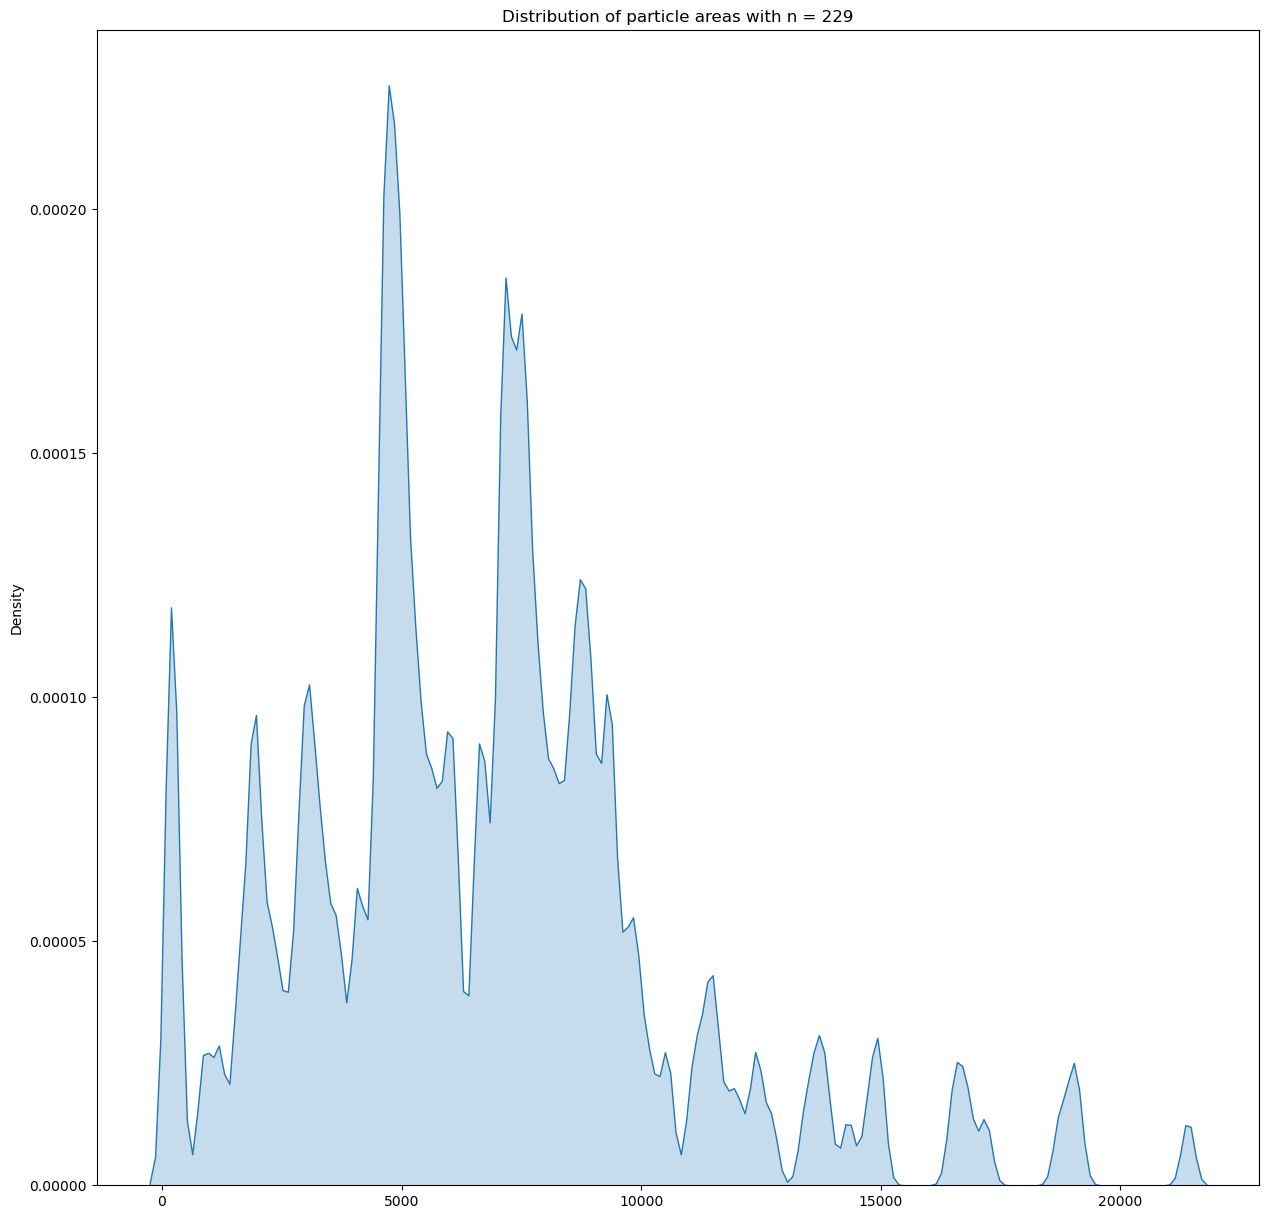

In [48]:
da.get_areas()
da.density_plot(smoothing=0.1)

10555
[962, 573, 131, 143]


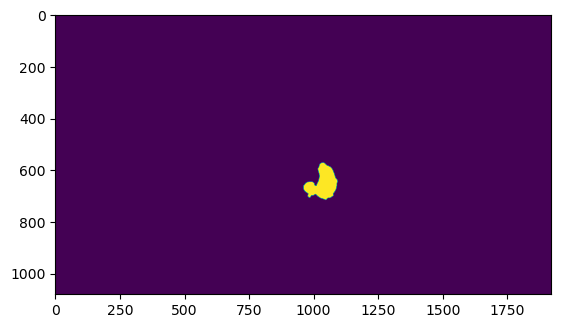

In [49]:
import matplotlib.pyplot as plt
mask_n = 2
ann_n = 6
mask = da.masks[mask_n]
sorted_anns = sorted(mask, key=(lambda x: x['area']), reverse=True)
print(sorted_anns[ann_n]['area'])
print(sorted_anns[ann_n]["bbox"])
plt.imshow(sorted_anns[ann_n]["segmentation"])

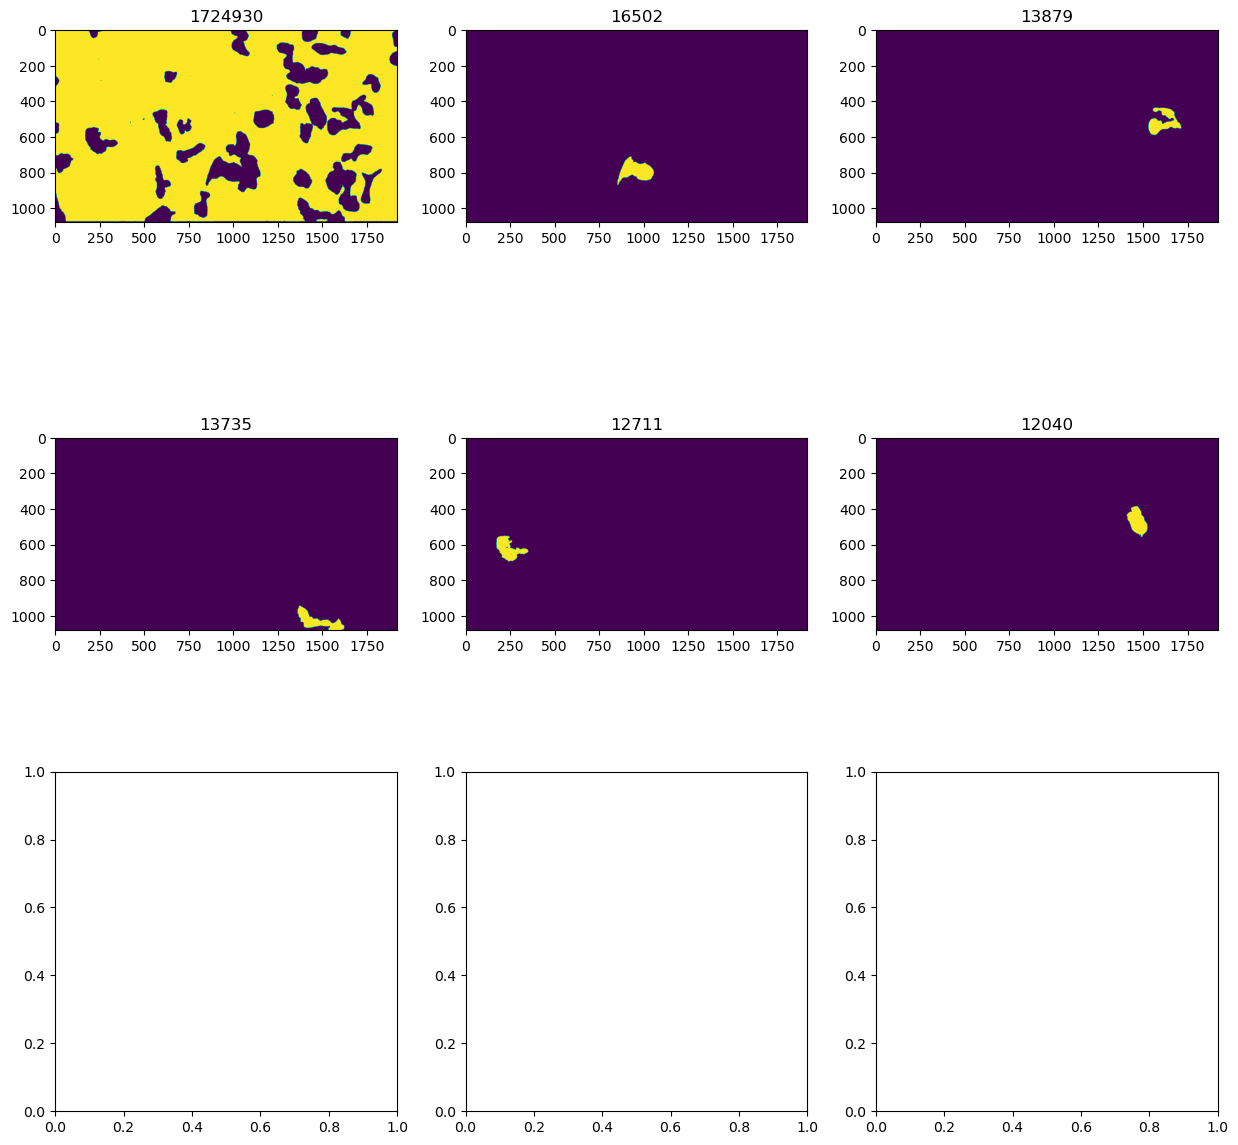

In [50]:
import numpy as np
size = int(np.sqrt(ann_n)+1)
fig, axs = plt.subplots(size, size, figsize=(15, 15))
axs = axs.ravel()
start = 0
for i in range(start, start+ann_n):
    axs[i-start].imshow(sorted_anns[i]["segmentation"])
    axs[i-start].set_title(sorted_anns[i]["area"])

328
325


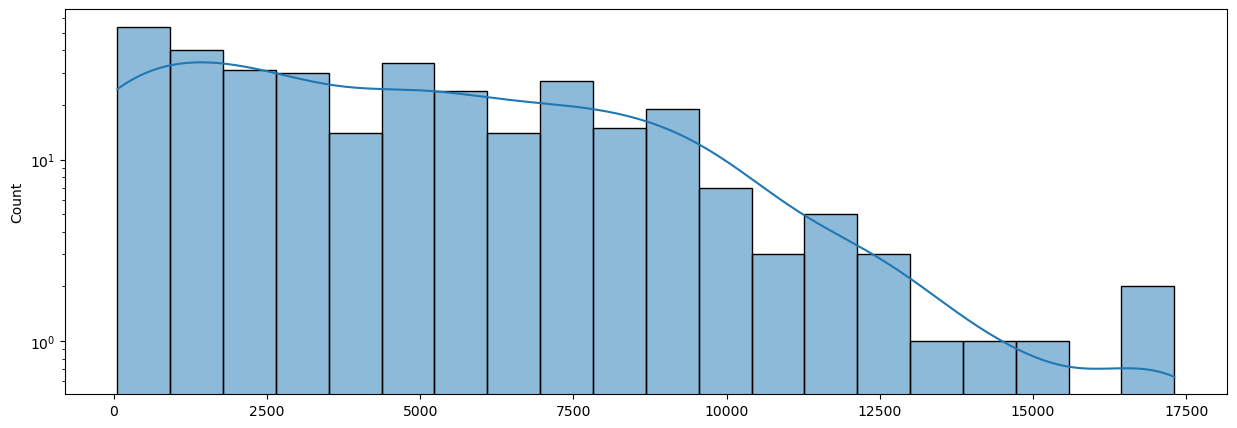

In [61]:
from pprint import pprint
import seaborn as sns

from scipy import stats
areas = sorted([mask["area"] for masks in da.masks for mask in masks])
print(len(areas))
z_scores = stats.zscore(areas)
areas = [area for i, area in enumerate(areas) if z_scores[i] < 0.0001]
print(len(areas))
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(areas, kde=True, bins=20)
axs.set_yscale("log")

In [55]:
# areas to csv
import pandas as pd
df = pd.DataFrame(areas)
df.to_csv("B7_areas.csv", index=False, header=False)

In [22]:
# pickle da object
import pickle
with open("da.pkl", "wb") as f:
    pickle.dump({"areas": da.areas, "masks": da.masks}, f)


In [1]:
# load da object
import pickle
with open("da.pkl", "rb") as f:
    da = pickle.load(f)
    